# **Setup and Installations**

In [ ]:
# Install all necessary packages quietly
!pip install -q transformers accelerate bitsandbytes sentencepiece
!pip install -q radon
!pip install -q ipywidgets
!pip install -q pandas matplotlib seaborn

# Import all libraries after installation
import torch
import re
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
from huggingface_hub import notebook_login
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from radon.complexity import cc_visit
from radon.raw import analyze
from radon.metrics import mi_visit
from IPython.display import display, clear_output, HTML

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.8 MB/s eta 0:00:00


# **Secure Hugging Face Login**

In [ ]:
notebook_login()
print("Login successfull!")

Login successfull!


# **Configuration & Backend Engine**

In [ ]:
 # --- Model Configuration ---
MODEL_CONFIG = {
    "DeepSeek-Coder": "deepseek-ai/deepseek-coder-1.3b-instruct",
    "Phi-2": "microsoft/phi-2",
    "Gemma-2B-IT": "google/gemma-2b-it"
}

# --- Backend Engine: Code Generation ---
def generate_code(model, tokenizer, prompt):
    """Generates code from a given model and prompt."""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Generate text
    outputs = model.generate(
        **inputs,
        max_new_tokens=512,
        num_return_sequences=1,
        do_sample=True,
        temperature=0.2,
        top_k=50,
        top_p=0.95,
        pad_token_id=tokenizer.eos_token_id
    )

    # Decode and clean the output
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract code block (handles ```python ... ``` and other formats)
    code_match = re.search(r'```(?:\w+\n)?(.*?)```', generated_text, re.DOTALL)
    if code_match:
        return code_match.group(1).strip()
    # Fallback if no code block is found, return text after prompt
    return generated_text[len(prompt):].strip()


# --- Backend Engine: Evaluation Metrics ---
def calculate_loc(code_string):
    """Calculates the lines of code (LOC)."""
    return len([line for line in code_string.split('\n') if line.strip()])

def calculate_complexity(code_string):
    """Calculates average cyclomatic complexity."""
    try:
        complexity_results = cc_visit(code_string)
        if not complexity_results:
            return 0
        total_complexity = sum(block.complexity for block in complexity_results)
        return total_complexity / len(complexity_results)
    except Exception:
        return 0 # Return 0 if parsing fails

def calculate_maintainability(code_string):
    """Calculates the maintainability index."""
    try:
        # Radon requires a non-empty string to avoid errors
        if not code_string.strip():
            return 0
        return mi_visit(code_string, multi=True)
    except Exception:
        return 0 # Return 0 if parsing fails

print("✅ Configuration and backend engine are ready.")

✅ Configuration and backend engine are ready.


# **Pre-Loading All AI Models**

In [ ]:
models = {}
tokenizers = {}

print("🚀 Starting to load models. This may take a few minutes...")

for name, path in MODEL_CONFIG.items():
    print(f"\nLoading {name} ({path})...")
    try:
        # Load the tokenizer
        tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True)
        # Handle cases where pad_token is not set
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        # Load the model with optimizations for Colab
        model = AutoModelForCausalLM.from_pretrained(
            path,
            torch_dtype="auto", # Use bfloat16 if available
            device_map="auto", # Automatically use the GPU
            trust_remote_code=True
        )

        models[name] = model
        tokenizers[name] = tokenizer
        print(f"✅ Successfully loaded {name}.")
    except Exception as e:
        print(f"❌ Failed to load {name}. Error: {e}")

print("\n🎉 All models loaded and ready for inference!")

🚀 Starting to load models. This may take a few minutes...

Loading DeepSeek-Coder (deepseek-ai/deepseek-coder-1.3b-instruct)...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.69G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

✅ Successfully loaded DeepSeek-Coder.

Loading Phi-2 (microsoft/phi-2)...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

✅ Successfully loaded Phi-2.

Loading Gemma-2B-IT (google/gemma-2b-it)...


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

✅ Successfully loaded Gemma-2B-IT.

🎉 All models loaded and ready for inference!


# **UI #1 – Benchmark All Models**

In [ ]:
# --- UI Widgets ---
prompt_input_1 = widgets.Textarea(
    value="Write a Python function to find the factorial of a number using recursion.",
    placeholder='Enter your code prompt here...',
    description='Prompt:',
    layout=widgets.Layout(width='90%', height='100px')
)

run_button_1 = widgets.Button(
    description="Benchmark All Models",
    button_style='success',
    icon='cogs'
)

output_area_1 = widgets.Output()

# --- Global results list for visualization ---
benchmark_results = []

# --- Button Click Logic ---
def on_benchmark_button_clicked(b):
    with output_area_1:
        clear_output(wait=True)
        prompt_text = prompt_input_1.value
        if not prompt_text:
            print("Please enter a prompt.")
            return

        print("🚀 Generating and evaluating... Please wait.")

        results = []
        for name, model in models.items():
            print(f"\n--- Processing with {name} ---")
            tokenizer = tokenizers[name]

            # Generate and Evaluate
            generated_code = generate_code(model, tokenizer, prompt_text)
            loc = calculate_loc(generated_code)
            complexity = calculate_complexity(generated_code)
            maintainability = calculate_maintainability(generated_code)

            # Store results
            result_data = {
                "Model": name,
                "LOC": loc,
                "Avg. Complexity": f"{complexity:.2f}",
                "Maintainability": f"{maintainability:.2f}",
            }
            results.append(result_data)

            # Also append to global list for final report
            benchmark_results.append({
                "Prompt": prompt_text,
                "Model": name,
                "LOC": loc,
                "Complexity": complexity,
                "Maintainability": maintainability
            })

            # Display results
            print(f"Generated Code:\n```python\n{generated_code}\n```")

        # Display results in a clean table
        df = pd.DataFrame(results)
        print("\n--- 📊 Benchmark Summary ---")
        display(df)

# Link button to function
run_button_1.on_click(on_benchmark_button_clicked)

# Display the UI
print("### UI #1: Benchmark All Models")
display(prompt_input_1, run_button_1, output_area_1)

### UI #1: Benchmark All Models


Textarea(value='Write a Python function to find the factorial of a number using recursion.', description='Prom…

Button(button_style='success', description='Benchmark All Models', icon='cogs', style=ButtonStyle())

Output()

# **UI #2 – Inspect Models with Checkboxes**

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

# --- UI Widgets ---
prompt_input_2 = widgets.Textarea(
    value="Create a Python class for a simple linked list with methods to append and print.",
    placeholder='Enter your code prompt here...',
    description='Prompt:',
    layout=widgets.Layout(width='90%', height='100px')
)

# Create checkboxes for each model
model_checkboxes = [widgets.Checkbox(value=True, description=name) for name in models.keys()]
checkbox_container = widgets.HBox(model_checkboxes, layout=widgets.Layout(margin='10px 0'))

run_button_2 = widgets.Button(
    description="Inspect Selected Models",
    button_style='primary',
    icon='search'
)

output_area_2 = widgets.Output()

# --- Button Click Logic ---
def on_inspect_button_clicked(b):
    with output_area_2:
        clear_output(wait=True)
        prompt_text = prompt_input_2.value
        selected_models = [cb.description for cb in model_checkboxes if cb.value]

        if not prompt_text:
            print("Please enter a prompt.")
            return
        if not selected_models:
            print("Please select at least one model.")
            return

        print(f"🚀 Generating for: {', '.join(selected_models)}...")

        results = []
        for name in selected_models:
            print(f"\n--- Processing with {name} ---")
            model = models[name]
            tokenizer = tokenizers[name]

            # Generate and Evaluate
            generated_code = generate_code(model, tokenizer, prompt_text)
            loc = calculate_loc(generated_code)
            complexity = calculate_complexity(generated_code)
            maintainability = calculate_maintainability(generated_code)

            # Store results
            results.append({
                "Model": name,
                "LOC": loc,
                "Avg. Complexity": f"{complexity:.2f}",
                "Maintainability": f"{maintainability:.2f}",
            })

            # Display results
            print(f"Generated Code:\n```python\n{generated_code}\n```")

        # Display results in a table
        df = pd.DataFrame(results)
        print("\n--- 🔎 Inspection Summary ---")
        display(df)

# Link button to function
run_button_2.on_click(on_inspect_button_clicked)

# Display the UI
print("### UI #2: Inspect Models with Checkboxes")
display(prompt_input_2, checkbox_container, run_button_2, output_area_2)

### UI #2: Inspect Models with Checkboxes


Textarea(value='Create a Python class for a simple linked list with methods to append and print.', description…

Button(button_style='primary', description='Inspect Selected Models', icon='search', style=ButtonStyle())

Output()

# **Final Analysis and Visualization Report**

--- 📋 Final Performance Report ---


,Model,LOC,Complexity,Maintainability
0,DeepSeek-Coder,10.0,0.0,0.00
1,Gemma-2B-IT,8.0,3.0,69.20
2,Phi-2,5.0,2.0,74.66


/tmp/ipython-input-3983000968.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='Model', y='LOC', data=avg_metrics, palette='viridis')
/tmp/ipython-input-3983000968.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='Model', y='Complexity', data=avg_metrics, palette='plasma')
/tmp/ipython-input-3983000968.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[2], x='Model', y='Maintainability', data=avg_metrics, palette='magma')


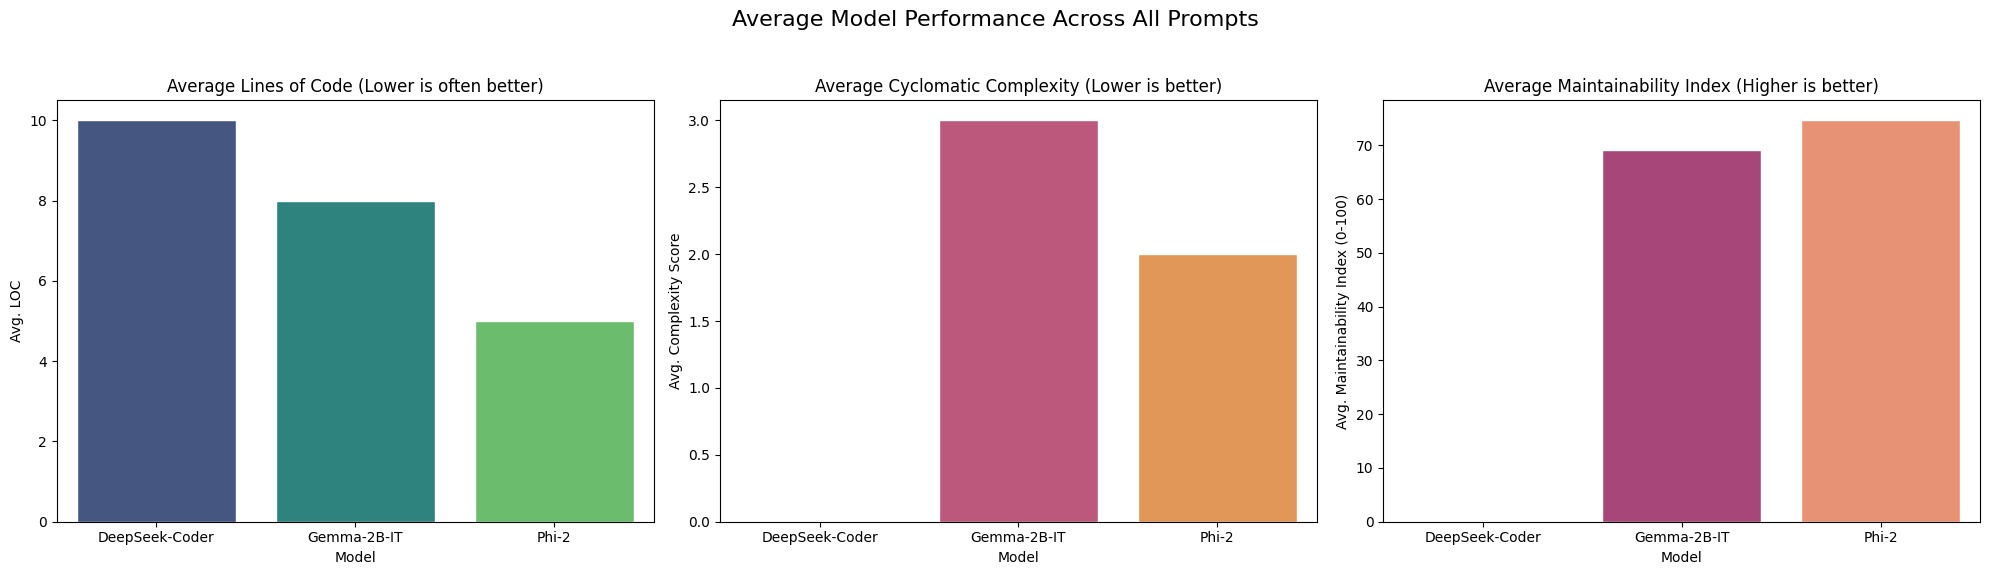

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- !! IMPORTANT !! ---
# 1. Define your 10 test prompts here.
# 2. Run EACH of these through UI #1 above to collect the data before running this cell.
sample_prompts = [
    "Write a Python function to find the factorial of a number using recursion.",
    "Create a Python class for a simple linked list with methods to append and print.",
    "Generate a Python script to read a CSV file named 'data.csv' and print its contents.",
    "Write a function in Python that checks if a string is a palindrome.",
    "Implement a binary search algorithm in Python.",
    "Create a simple Flask web application with one route that returns 'Hello, World!'.",
    "Write a Python function to calculate the nth Fibonacci number.",
    "Generate a SQL query to select all users from a 'users' table who signed up in the last 30 days.",
    "Write a Javascript function to fetch data from an API endpoint 'https://api.example.com/data' and log it to the console.",
    "Create a Python decorator that logs the execution time of a function."
]

# --- Data Aggregation and Visualization ---

# Check if results were collected
if not benchmark_results:
    print("❌ No benchmark data found. Please run your prompts through UI #1 first.")
else:
    # Convert collected data to a DataFrame
    report_df = pd.DataFrame(benchmark_results)

    # Calculate average metrics per model
    avg_metrics = report_df.groupby('Model').agg({
        'LOC': 'mean',
        'Complexity': 'mean',
        'Maintainability': 'mean'
    }).reset_index()

    print("--- 📋 Final Performance Report ---")
    display(avg_metrics.round(2))

    # --- Plotting ---
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Average Model Performance Across All Prompts', fontsize=16)
    sns.set_style("whitegrid")

    # Plot 1: Average Lines of Code (LOC)
    sns.barplot(ax=axes[0], x='Model', y='LOC', data=avg_metrics, palette='viridis')
    axes[0].set_title('Average Lines of Code (Lower is often better)')
    axes[0].set_ylabel('Avg. LOC')

    # Plot 2: Average Cyclomatic Complexity
    sns.barplot(ax=axes[1], x='Model', y='Complexity', data=avg_metrics, palette='plasma')
    axes[1].set_title('Average Cyclomatic Complexity (Lower is better)')
    axes[1].set_ylabel('Avg. Complexity Score')

    # Plot 3: Average Maintainability Index
    sns.barplot(ax=axes[2], x='Model', y='Maintainability', data=avg_metrics, palette='magma')
    axes[2].set_title('Average Maintainability Index (Higher is better)')
    axes[2].set_ylabel('Avg. Maintainability Index (0-100)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()